In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, False)
])

In [3]:
d = 8
dm = 5
T = 200
n = 20
dict_k = 6
shape_record = {}
shape_record[0] = [(1,d)]

def synthetic_binClass(d, dm, dict_k, T, n, random_state = 110):
    np.random.seed(110)
    L_gt = np.random.randn(d,dict_k)

    D_gt = np.random.randn(dm,dict_k)

    s = np.random.uniform(0, 2, size=(dict_k, T))
    s[s>=1] = 0

    ones = np.atleast_2d(np.ones(n))
    x = np.random.normal(0, 1.0, size=(d-1,n))*2
    x = np.vstack((ones, x))

    w = L_gt @ s
    a = D_gt @ s

    y = utils.sigmoid(w.T @ x)
    y[y >=0.5] = np.ones_like(y[y >=0.5])
    y[y <0.5] = np.zeros_like(y[y < 0.5])

    print('y ', np.sum(y, axis=1))

    a = a.T
    w = w.T
    x = x.T

    dataset = [(a[t,:], np.expand_dims(w[t,:], axis=0), x, np.expand_dims(y[t,:], axis=1)) for t in range(T)]

    print(a[1,:].shape, w[1,:].shape, x.shape, y[1,:].shape)
    return dataset

dataset = synthetic_binClass(d, dm, dict_k, T, n, random_state = 999)
print('len dataset ', len(dataset))
kb_size = 10
train_size = 140
total_len = len(dataset)
test_size = total_len - kb_size - train_size

indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
train_a, train_w, train_x, train_y = next(iter(train_loader))
train_a, train_w, train_x, train_y = train_a.float(), train_w.float(), train_x.float(), train_y.float()
print(train_a.shape, train_w.shape, train_x.shape, train_y.shape)

y  [12. 13. 17. 11.  7. 11. 11. 10.  8. 11. 11. 11. 11. 12. 17. 14. 15. 12.
 11.  8. 10. 14. 17. 17. 11. 16. 10. 10. 11. 12. 11. 11. 12. 16. 12. 11.
 11. 14. 14. 12. 17. 17.  9. 14. 11. 11. 12. 11. 13. 13. 10. 12. 12. 11.
 14. 16. 17. 14. 16. 13. 11. 15. 12. 12. 14. 15. 14. 16. 13. 13. 10. 13.
  9. 12. 10. 12. 12. 14. 10. 17. 11.  9. 11. 11. 10. 11. 14.  7. 12. 13.
 14. 12. 12. 11. 15. 15. 14. 13. 10. 14. 11. 11. 14. 16. 12. 17. 15. 12.
 13. 14. 11. 11. 20. 12. 11. 12. 14. 13. 12. 11. 12. 11. 11. 13. 14. 17.
 13. 12. 17. 12. 13. 16. 15.  7. 13. 13. 12. 11. 10. 16. 11. 11.  8. 10.
 13. 14.  9. 13.  8. 13. 20. 11. 10. 12. 11. 14. 11. 11. 11.  8.  9. 15.
 12. 14. 12. 12. 10. 14. 14. 13. 11. 10. 11. 13. 12. 14. 17. 17.  8. 16.
 11.  7. 14. 14. 13. 12. 11. 12. 15. 10. 14. 11. 12. 14. 11. 10. 14. 12.
 11. 11.]
(5,) (8,) (20, 8) (20,)
len dataset  200
10
140
50
torch.Size([140, 1, 5]) torch.Size([140, 1, 8]) torch.Size([140, 20, 8]) torch.Size([140, 20, 1])


5
8
20
120
120
20
num of hp  25
rho for w_kb 0.1; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 6.125453495668868; m train metric 0.846666666666667; m test metric 0.7775; align loss  4.7777910232543945
100/1500 o_loss 5.193022674756746; m train metric 0.8175; m test metric 0.7750000000000001; align loss  0.06305522471666336
200/1500 o_loss 4.368812458465497; m train metric 0.8154166666666666; m test metric 0.79; align loss  0.025412676855921745
300/1500 o_loss 3.7425340954214334; m train metric 0.8099999999999999; m test metric 0.7875000000000002; align loss  0.022540424019098282
400/1500 o_loss 3.231037317464749; m train metric 0.8091666666666664; m test metric 0.7825; align loss  0.019899548962712288
500/1500 o_loss 2.810613749672969; m train metric 0.8054166666666666; m test metric 0.7874999999999999; align loss  0.017475059255957603
600/1500 o_loss 2.463038071617484; m train metric 0.8050000000000002; m test metric 0.7899999999999998; align l

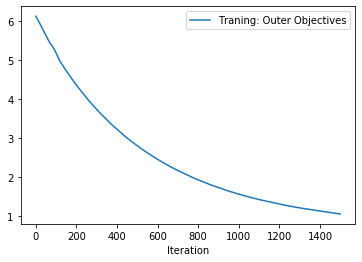

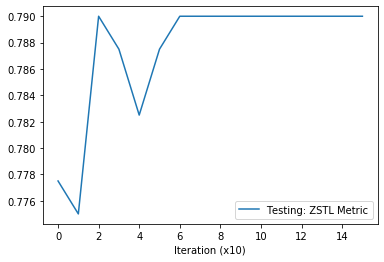

mean metric 0.79
New best acc 0.79
rho for w_kb 0.1; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 6.125453495668868; m train metric 0.846666666666667; m test metric 0.7775000000000001; align loss  0.4915315806865692
100/1500 o_loss 5.190838764545818; m train metric 0.8041666666666671; m test metric 0.7600000000000001; align loss  0.03545691817998886
200/1500 o_loss 4.386370940506458; m train metric 0.8112500000000001; m test metric 0.7625000000000001; align loss  0.031453877687454224
300/1500 o_loss 3.743314350272218; m train metric 0.8158333333333335; m test metric 0.76; align loss  0.02795686572790146
400/1500 o_loss 3.2177759679034352; m train metric 0.8216666666666669; m test metric 0.7625000000000001; align loss  0.024926532059907913
500/1500 o_loss 2.7861736244832476; m train metric 0.8225000000000003; m test metric 0.7675000000000001; align loss  0.02223343774676323
600/1500 o_loss 2.431133493905266; m train metric 0.8212500000000003;

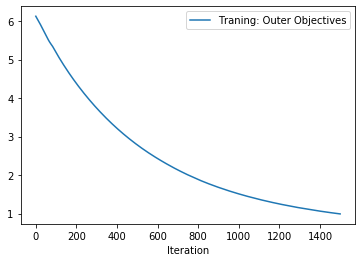

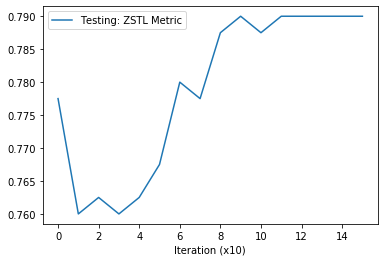

mean metric 0.7899999999999998
rho for w_kb 0.1; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 6.125453495668868; m train metric 0.8483333333333337; m test metric 0.78; align loss  0.0628473311662674
100/1500 o_loss 5.199836931936443; m train metric 0.8475000000000004; m test metric 0.8099999999999999; align loss  0.029261130839586258
200/1500 o_loss 4.3758125194658835; m train metric 0.8441666666666668; m test metric 0.8025; align loss  0.025292610749602318
300/1500 o_loss 3.714777826021115; m train metric 0.8458333333333339; m test metric 0.8175000000000001; align loss  0.02155880816280842
400/1500 o_loss 3.1908092505609; m train metric 0.8470833333333341; m test metric 0.82; align loss  0.018434103578329086
500/1500 o_loss 2.759827836602926; m train metric 0.8474999999999999; m test metric 0.8175000000000001; align loss  0.015796732157468796
600/1500 o_loss 2.394878129971524; m train metric 0.8458333333333338; m test metric 0.81500000000

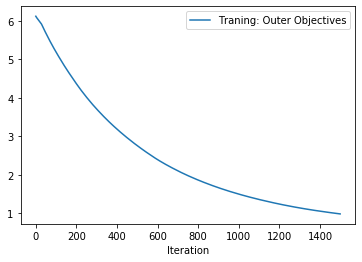

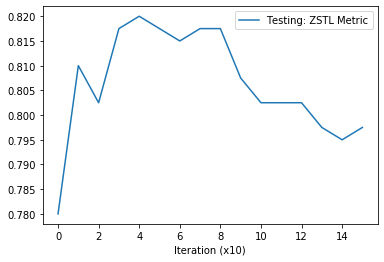

mean metric 0.7975
New best acc 0.7975
rho for w_kb 0.1; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 6.125453495668868; m train metric 0.8508333333333334; m test metric 0.78; align loss  0.01961306482553482
100/1500 o_loss 5.1929726076001925; m train metric 0.8595833333333335; m test metric 0.8375; align loss  0.006403368432074785
200/1500 o_loss 4.3701539589868235; m train metric 0.8679166666666672; m test metric 0.8325000000000002; align loss  0.005494844168424606
300/1500 o_loss 3.697522946462656; m train metric 0.8687500000000004; m test metric 0.8325000000000001; align loss  0.004756026901304722
400/1500 o_loss 3.1465387655422092; m train metric 0.8675; m test metric 0.8150000000000001; align loss  0.004018630366772413
500/1500 o_loss 2.724176391835014; m train metric 0.86375; m test metric 0.8299999999999998; align loss  0.0033970498479902744
600/1500 o_loss 2.3781395153763394; m train metric 0.8608333333333339; m test metric 0.84

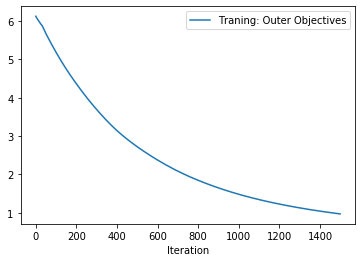

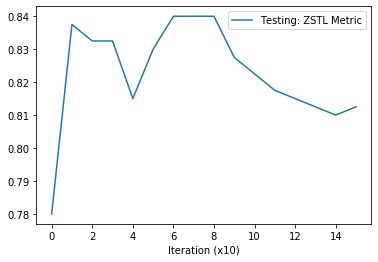

mean metric 0.8124999999999998
New best acc 0.8124999999999998
rho for w_kb 0.1; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 6.125453495668868; m train metric 0.8508333333333337; m test metric 0.78; align loss  0.015233292244374752
100/1500 o_loss 5.212080200575292; m train metric 0.8558333333333338; m test metric 0.845; align loss  0.00283691193908453
200/1500 o_loss 4.354075595363975; m train metric 0.8687500000000004; m test metric 0.8425; align loss  0.0024559495504945517
300/1500 o_loss 3.670369875632847; m train metric 0.8654166666666667; m test metric 0.845; align loss  0.002155080670490861
400/1500 o_loss 3.144599812167386; m train metric 0.8625000000000005; m test metric 0.8324999999999998; align loss  0.0018660844070836902
500/1500 o_loss 2.7220495373631515; m train metric 0.8633333333333337; m test metric 0.8424999999999999; align loss  0.0015635030576959252
600/1500 o_loss 2.37540919057404; m train metric 0.8608333333333338; m

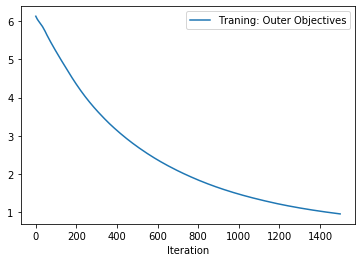

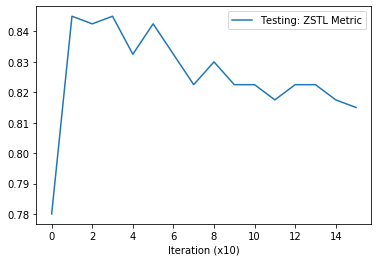

mean metric 0.8150000000000001
New best acc 0.8150000000000001
rho for w_kb 0.01; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 1.0630122658486167; m train metric 0.8466666666666669; m test metric 0.7775000000000001; align loss  4.777792930603027
100/1500 o_loss 0.9747440613185366; m train metric 0.8125000000000001; m test metric 0.7625000000000003; align loss  0.0632406696677208
200/1500 o_loss 0.8294769308219354; m train metric 0.817083333333333; m test metric 0.795; align loss  0.026335114613175392
300/1500 o_loss 0.7622205528120201; m train metric 0.8183333333333334; m test metric 0.795; align loss  0.024009358137845993
400/1500 o_loss 0.7111764190097649; m train metric 0.8183333333333332; m test metric 0.795; align loss  0.021642403677105904
500/1500 o_loss 0.6711133275181055; m train metric 0.8154166666666669; m test metric 0.785; align loss  0.019287414848804474
600/1500 o_loss 0.6390273720026016; m train metric 0.8083333333333335; m test 

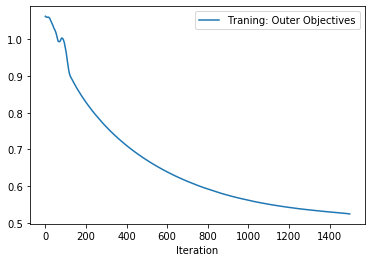

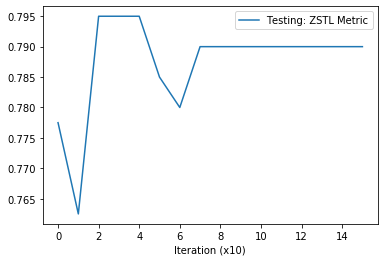

mean metric 0.79
rho for w_kb 0.01; mu for a_kb 0.01;
init mean test metric 0.7799999999999999; align loss 0.5069708824157715
1/1500 o_loss 1.0630122658486167; m train metric 0.8466666666666668; m test metric 0.7774999999999999; align loss  0.49153345823287964
100/1500 o_loss 0.9728868967543046; m train metric 0.805; m test metric 0.7575000000000001; align loss  0.03577122464776039
200/1500 o_loss 0.8532312201956909; m train metric 0.8158333333333339; m test metric 0.7775000000000001; align loss  0.03225107491016388
300/1500 o_loss 0.7695307329917948; m train metric 0.8241666666666669; m test metric 0.7725; align loss  0.02904682792723179
400/1500 o_loss 0.7027082153906425; m train metric 0.8275; m test metric 0.7750000000000001; align loss  0.02628214657306671
500/1500 o_loss 0.650639523503681; m train metric 0.826666666666667; m test metric 0.775; align loss  0.0238608680665493
600/1500 o_loss 0.6101712261637051; m train metric 0.8283333333333336; m test metric 0.78; align loss  0.02

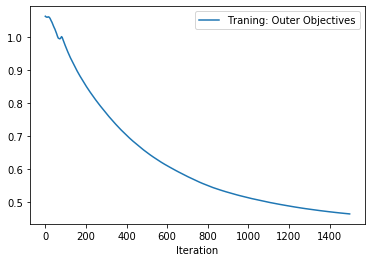

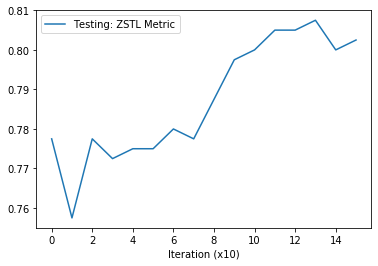

mean metric 0.8025
rho for w_kb 0.01; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 1.0630122658486167; m train metric 0.8483333333333335; m test metric 0.78; align loss  0.06284911930561066
100/1500 o_loss 0.9809570649638772; m train metric 0.8462500000000002; m test metric 0.8074999999999999; align loss  0.030128588899970055
200/1500 o_loss 0.8432819001066187; m train metric 0.8454166666666665; m test metric 0.8075000000000001; align loss  0.02646668814122677
300/1500 o_loss 0.7370340958237648; m train metric 0.8462500000000002; m test metric 0.82; align loss  0.02321075275540352
400/1500 o_loss 0.668828685178111; m train metric 0.8529166666666668; m test metric 0.8299999999999998; align loss  0.02011885866522789
500/1500 o_loss 0.6149289779054622; m train metric 0.8558333333333337; m test metric 0.8324999999999999; align loss  0.017326578497886658
600/1500 o_loss 0.5714849002969762; m train metric 0.8558333333333337; m test metric 0.8375

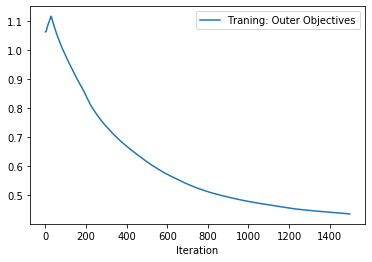

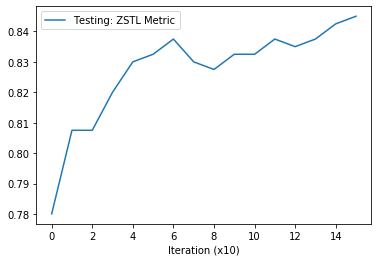

mean metric 0.845
New best acc 0.845
rho for w_kb 0.01; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 1.0630122658486167; m train metric 0.8508333333333339; m test metric 0.78; align loss  0.019614748656749725
100/1500 o_loss 0.9759524749591947; m train metric 0.8600000000000004; m test metric 0.8349999999999997; align loss  0.006465284153819084
200/1500 o_loss 0.8401732299476862; m train metric 0.8708333333333339; m test metric 0.82; align loss  0.00568142207339406
300/1500 o_loss 0.728376004161934; m train metric 0.8716666666666668; m test metric 0.8274999999999999; align loss  0.005169950425624847
400/1500 o_loss 0.6315280627769728; m train metric 0.8720833333333335; m test metric 0.8324999999999999; align loss  0.004615929909050465
500/1500 o_loss 0.5767850264906883; m train metric 0.8741666666666669; m test metric 0.8425; align loss  0.0040204208344221115
600/1500 o_loss 0.541720935360839; m train metric 0.871250000000001; m test met

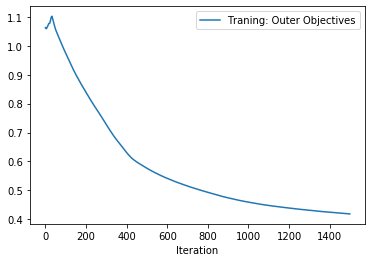

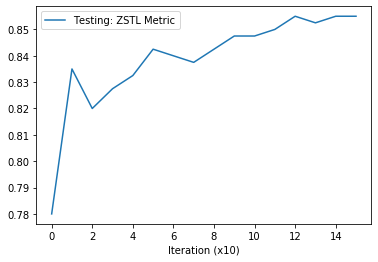

mean metric 0.8549999999999999
New best acc 0.8549999999999999
rho for w_kb 0.01; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 1.0630122658486167; m train metric 0.8508333333333334; m test metric 0.78; align loss  0.015234961174428463
100/1500 o_loss 0.991226953205963; m train metric 0.855416666666667; m test metric 0.8425; align loss  0.002829111646860838
200/1500 o_loss 0.8280799778799216; m train metric 0.8700000000000003; m test metric 0.8400000000000001; align loss  0.0024762428365647793
300/1500 o_loss 0.7149958668276668; m train metric 0.8750000000000008; m test metric 0.8425; align loss  0.0022807929199188948
400/1500 o_loss 0.6306959535616139; m train metric 0.8658333333333341; m test metric 0.8450000000000001; align loss  0.002088400302454829
500/1500 o_loss 0.578509583324194; m train metric 0.8645833333333337; m test metric 0.865; align loss  0.0018564923666417599
600/1500 o_loss 0.545049071405083; m train metric 0.8695833333333

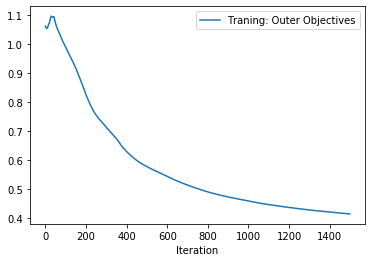

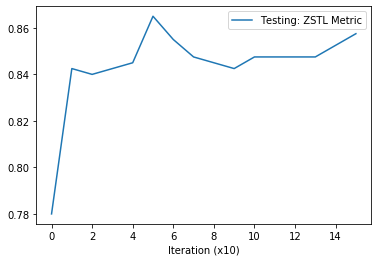

mean metric 0.8574999999999999
New best acc 0.8574999999999999
rho for w_kb 0.001; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 0.5567681689436237; m train metric 0.846666666666667; m test metric 0.7775; align loss  4.777794361114502
100/1500 o_loss 0.5479649264986317; m train metric 0.8191666666666669; m test metric 0.775; align loss  0.06473862379789352
200/1500 o_loss 0.4608091418941816; m train metric 0.8183333333333332; m test metric 0.7924999999999999; align loss  0.030504290014505386
300/1500 o_loss 0.4452835285415252; m train metric 0.8233333333333337; m test metric 0.7875000000000001; align loss  0.030231555923819542
400/1500 o_loss 0.4361263232926528; m train metric 0.8279166666666667; m test metric 0.7925; align loss  0.02980262041091919
500/1500 o_loss 0.4299064626296361; m train metric 0.8295833333333333; m test metric 0.7899999999999999; align loss  0.029279328882694244
600/1500 o_loss 0.42557041433950266; m train metric 0.83041666

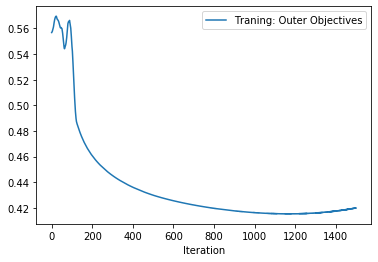

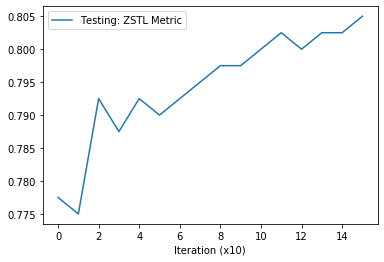

mean metric 0.8049999999999999
rho for w_kb 0.001; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 0.5567681689436237; m train metric 0.8466666666666669; m test metric 0.7775000000000001; align loss  0.4915352165699005
100/1500 o_loss 0.5448067294433713; m train metric 0.805416666666667; m test metric 0.765; align loss  0.03797941282391548
200/1500 o_loss 0.48650978691875935; m train metric 0.832916666666667; m test metric 0.7874999999999999; align loss  0.036545488983392715
300/1500 o_loss 0.45266289145996175; m train metric 0.837083333333333; m test metric 0.7949999999999999; align loss  0.03530951589345932
400/1500 o_loss 0.4256882761915525; m train metric 0.8395833333333336; m test metric 0.7949999999999999; align loss  0.03442925959825516
500/1500 o_loss 0.40311411234239736; m train metric 0.8424999999999999; m test metric 0.7974999999999999; align loss  0.03380899876356125
600/1500 o_loss 0.38407132929811877; m train metric 0.845; m test 

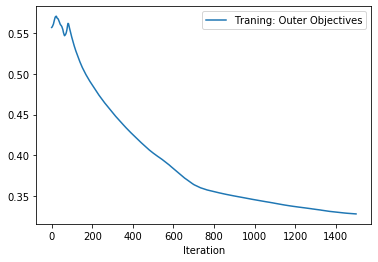

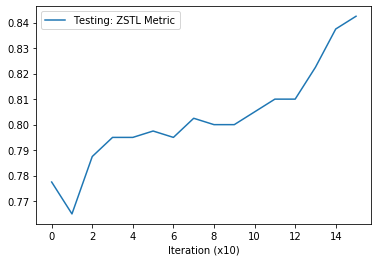

mean metric 0.8425
rho for w_kb 0.001; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 0.5567681689436237; m train metric 0.8483333333333334; m test metric 0.78; align loss  0.06285075843334198
100/1500 o_loss 0.5492717706908783; m train metric 0.8475; m test metric 0.805; align loss  0.03228398412466049
200/1500 o_loss 0.48035775708655515; m train metric 0.8491666666666672; m test metric 0.8075000000000001; align loss  0.031143495813012123
300/1500 o_loss 0.4142306766162316; m train metric 0.8579166666666669; m test metric 0.8324999999999999; align loss  0.03013153374195099
400/1500 o_loss 0.37954021310433744; m train metric 0.8658333333333339; m test metric 0.85; align loss  0.02934104949235916
500/1500 o_loss 0.3558906463906169; m train metric 0.8741666666666674; m test metric 0.8474999999999999; align loss  0.029003934934735298
600/1500 o_loss 0.33947621593251825; m train metric 0.8729166666666672; m test metric 0.8549999999999999; align 

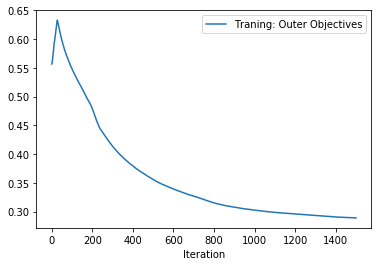

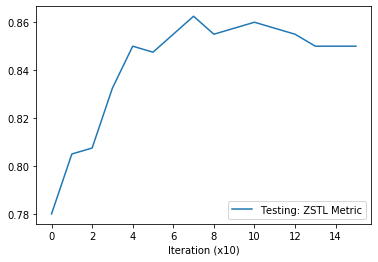

mean metric 0.8499999999999999
rho for w_kb 0.001; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 0.5567681689436237; m train metric 0.8508333333333336; m test metric 0.78; align loss  0.01961604319512844
100/1500 o_loss 0.5343479917695124; m train metric 0.8625000000000005; m test metric 0.8324999999999999; align loss  0.0072001246735453606
200/1500 o_loss 0.46124601289629935; m train metric 0.8795833333333339; m test metric 0.8275; align loss  0.007099013309925795
300/1500 o_loss 0.40530996276065706; m train metric 0.8816666666666674; m test metric 0.8524999999999998; align loss  0.007277114316821098
400/1500 o_loss 0.37834465022509295; m train metric 0.884583333333334; m test metric 0.86; align loss  0.0074758380651474
500/1500 o_loss 0.3566880538749198; m train metric 0.8891666666666675; m test metric 0.86; align loss  0.00762004591524601
600/1500 o_loss 0.33890194185078143; m train metric 0.8912500000000007; m test metric 0.85; align 

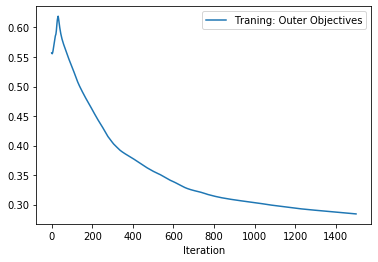

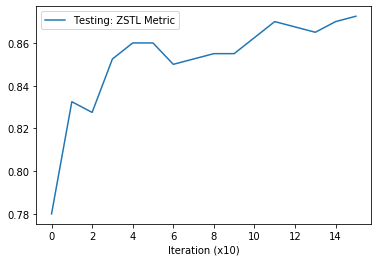

mean metric 0.8724999999999999
New best acc 0.8724999999999999
rho for w_kb 0.001; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 0.5567681689436237; m train metric 0.8508333333333336; m test metric 0.78; align loss  0.01523617934435606
100/1500 o_loss 0.5440796750908097; m train metric 0.861666666666667; m test metric 0.8550000000000001; align loss  0.003176734782755375
200/1500 o_loss 0.4603235591823856; m train metric 0.8779166666666675; m test metric 0.8525; align loss  0.003146497765555978
300/1500 o_loss 0.4019869497045875; m train metric 0.8812500000000008; m test metric 0.8600000000000001; align loss  0.00335936201736331
400/1500 o_loss 0.3785925381196042; m train metric 0.8808333333333338; m test metric 0.8550000000000001; align loss  0.003532924223691225
500/1500 o_loss 0.35412009224916496; m train metric 0.8800000000000002; m test metric 0.85; align loss  0.0036113481037318707
600/1500 o_loss 0.31670813852300245; m train metric 0.

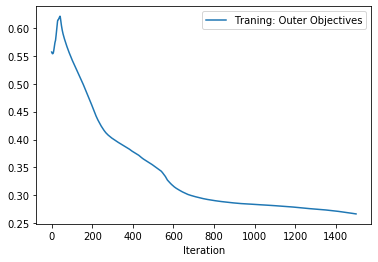

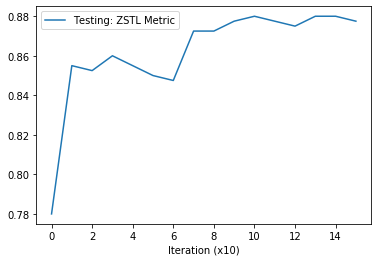

mean metric 0.8774999999999998
New best acc 0.8774999999999998
rho for w_kb 0.0001; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 0.5061437564591567; m train metric 0.846666666666667; m test metric 0.7775; align loss  4.777791500091553
100/1500 o_loss 0.5031638571992516; m train metric 0.817916666666667; m test metric 0.7750000000000001; align loss  0.06509581208229065
200/1500 o_loss 0.4192737755676111; m train metric 0.8204166666666667; m test metric 0.7975000000000001; align loss  0.03165629506111145
300/1500 o_loss 0.4060587881443401; m train metric 0.8245833333333337; m test metric 0.7899999999999999; align loss  0.032193589955568314
400/1500 o_loss 0.3981095135832826; m train metric 0.8283333333333333; m test metric 0.7874999999999999; align loss  0.03277292102575302
500/1500 o_loss 0.39289397407944004; m train metric 0.8304166666666667; m test metric 0.7899999999999999; align loss  0.033444952219724655
600/1500 o_loss 0.3893715073044101; m

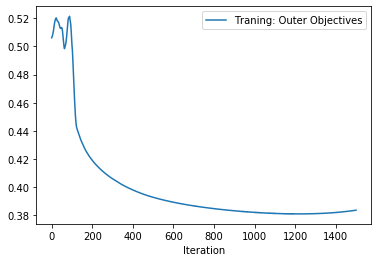

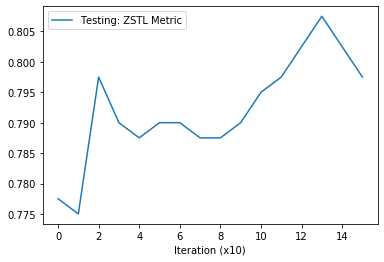

mean metric 0.7975
rho for w_kb 0.0001; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 0.5061437564591567; m train metric 0.846666666666667; m test metric 0.7775000000000001; align loss  0.49153244495391846
100/1500 o_loss 0.5001044270272057; m train metric 0.8083333333333339; m test metric 0.7675000000000001; align loss  0.038432102650403976
200/1500 o_loss 0.44594856730351845; m train metric 0.8329166666666669; m test metric 0.7899999999999998; align loss  0.0375492125749588
300/1500 o_loss 0.413672284844021; m train metric 0.837916666666667; m test metric 0.795; align loss  0.036906562745571136
400/1500 o_loss 0.3870213541512688; m train metric 0.8416666666666668; m test metric 0.7975; align loss  0.03673991188406944
500/1500 o_loss 0.36391922052328785; m train metric 0.845; m test metric 0.7925; align loss  0.03704799711704254
600/1500 o_loss 0.34102965841690697; m train metric 0.8500000000000006; m test metric 0.8024999999999999; align lo

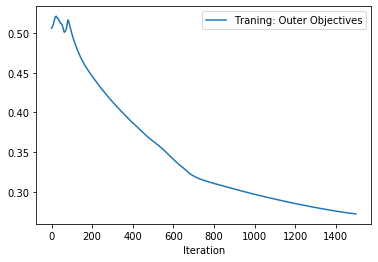

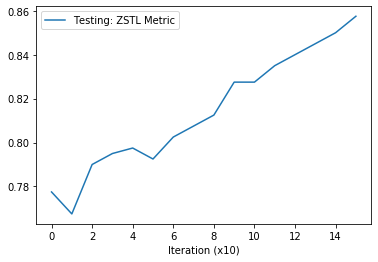

mean metric 0.8575000000000002
rho for w_kb 0.0001; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 0.5061437564591567; m train metric 0.8483333333333337; m test metric 0.78; align loss  0.06284796446561813
100/1500 o_loss 0.5031036037330826; m train metric 0.8483333333333334; m test metric 0.8025; align loss  0.032636187970638275
200/1500 o_loss 0.4368845877548059; m train metric 0.8562500000000008; m test metric 0.8125; align loss  0.032132912427186966
300/1500 o_loss 0.36413448381548125; m train metric 0.8641666666666669; m test metric 0.8300000000000001; align loss  0.03189072012901306
400/1500 o_loss 0.3314740932236115; m train metric 0.8729166666666672; m test metric 0.8550000000000001; align loss  0.031996116042137146
500/1500 o_loss 0.3133678168679277; m train metric 0.8754166666666675; m test metric 0.865; align loss  0.03221914917230606
600/1500 o_loss 0.3004337658174336; m train metric 0.8850000000000008; m test metric 0.875; align

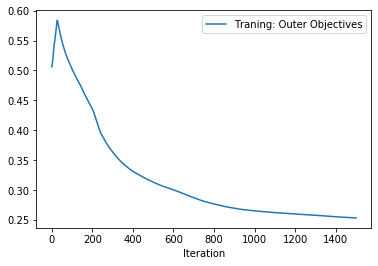

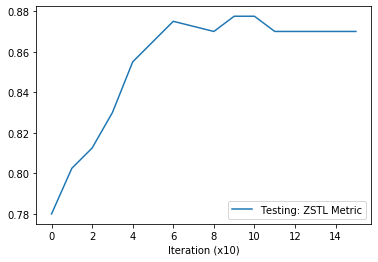

mean metric 0.8699999999999999
rho for w_kb 0.0001; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 0.5061437564591567; m train metric 0.8508333333333337; m test metric 0.78; align loss  0.01961323991417885
100/1500 o_loss 0.4835168821426729; m train metric 0.8637500000000001; m test metric 0.8324999999999999; align loss  0.00740923173725605
200/1500 o_loss 0.4165837664157152; m train metric 0.8775000000000003; m test metric 0.8324999999999999; align loss  0.0075420476496219635
300/1500 o_loss 0.36004270864650606; m train metric 0.8891666666666674; m test metric 0.8525; align loss  0.00809955969452858
400/1500 o_loss 0.3341958286861579; m train metric 0.8895833333333337; m test metric 0.8550000000000001; align loss  0.008549834601581097
500/1500 o_loss 0.3147047022047142; m train metric 0.891666666666667; m test metric 0.8550000000000001; align loss  0.008959110826253891
600/1500 o_loss 0.2963037860269348; m train metric 0.8862500000000002;

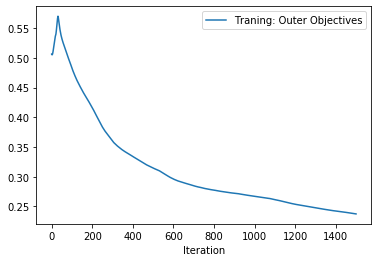

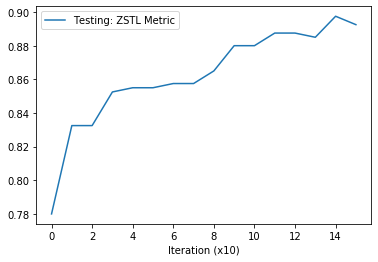

mean metric 0.8924999999999998
New best acc 0.8924999999999998
rho for w_kb 0.0001; mu for a_kb 1e-05;
init mean test metric 0.7800000000000001; align loss 0.01619485579431057
1/1500 o_loss 0.5061437564591567; m train metric 0.8508333333333334; m test metric 0.7800000000000001; align loss  0.01523341704159975
100/1500 o_loss 0.5005826740836103; m train metric 0.86375; m test metric 0.8474999999999999; align loss  0.0032300385646522045
200/1500 o_loss 0.3972042667058607; m train metric 0.8800000000000004; m test metric 0.8524999999999998; align loss  0.00332149351015687
300/1500 o_loss 0.36408563517034054; m train metric 0.8812500000000006; m test metric 0.86; align loss  0.003575193230062723
400/1500 o_loss 0.3436980377882719; m train metric 0.8812500000000008; m test metric 0.8550000000000001; align loss  0.003832258516922593
500/1500 o_loss 0.3262136910421153; m train metric 0.8787500000000006; m test metric 0.8525; align loss  0.004033615346997976
600/1500 o_loss 0.2891072669066489;

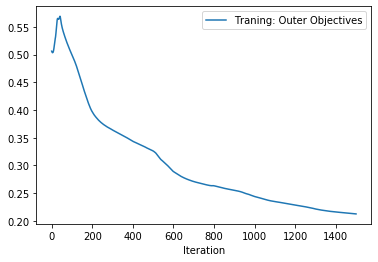

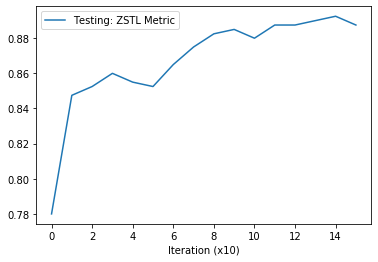

mean metric 0.8875
rho for w_kb 1e-05; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 0.501081315757862; m train metric 0.8466666666666673; m test metric 0.7775; align loss  4.777791500091553
100/1500 o_loss 0.49837330732261764; m train metric 0.8179166666666668; m test metric 0.7750000000000001; align loss  0.06509296596050262
200/1500 o_loss 0.4147670481625634; m train metric 0.8191666666666664; m test metric 0.7950000000000002; align loss  0.03171364590525627
300/1500 o_loss 0.40164240497009207; m train metric 0.8245833333333333; m test metric 0.7875000000000002; align loss  0.032364048063755035
400/1500 o_loss 0.3936164317749596; m train metric 0.8287500000000005; m test metric 0.7900000000000001; align loss  0.03308472782373428
500/1500 o_loss 0.3882336787413806; m train metric 0.8308333333333331; m test metric 0.7900000000000001; align loss  0.03392616659402847
600/1500 o_loss 0.3845643795677461; m train metric 0.8325; m test metric 0.790000

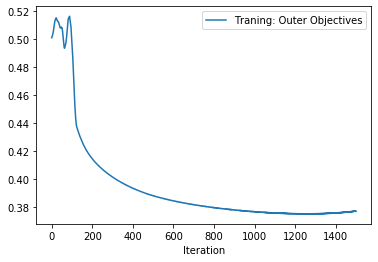

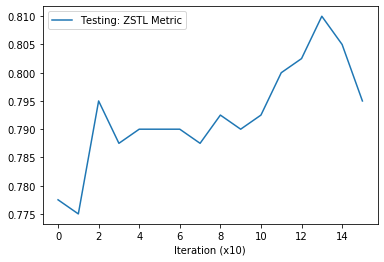

mean metric 0.7949999999999999
rho for w_kb 1e-05; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 0.501081315757862; m train metric 0.8466666666666669; m test metric 0.7775000000000001; align loss  0.4915321469306946
100/1500 o_loss 0.49490366198200114; m train metric 0.807916666666667; m test metric 0.7725000000000001; align loss  0.03843660652637482
200/1500 o_loss 0.4411052722794314; m train metric 0.8337500000000002; m test metric 0.7924999999999999; align loss  0.03780040889978409
300/1500 o_loss 0.4087338941637427; m train metric 0.8383333333333334; m test metric 0.7924999999999998; align loss  0.037517089396715164
400/1500 o_loss 0.3817322689729432; m train metric 0.8416666666666666; m test metric 0.7949999999999999; align loss  0.037720806896686554
500/1500 o_loss 0.3581341434813415; m train metric 0.8458333333333334; m test metric 0.7925000000000001; align loss  0.03835466504096985
600/1500 o_loss 0.333494092085554; m train metric 0.8

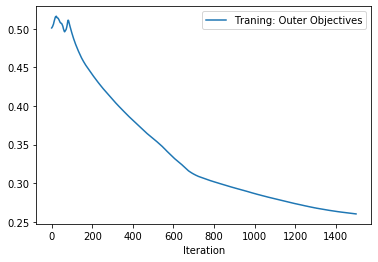

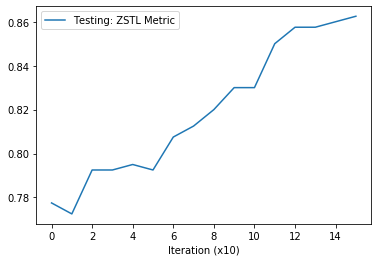

mean metric 0.8625
rho for w_kb 1e-05; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 0.501081315757862; m train metric 0.8483333333333338; m test metric 0.78; align loss  0.06284768879413605
100/1500 o_loss 0.4980663027226304; m train metric 0.8470833333333332; m test metric 0.8025; align loss  0.032722827047109604
200/1500 o_loss 0.431901167119698; m train metric 0.8554166666666667; m test metric 0.8125; align loss  0.03218623995780945
300/1500 o_loss 0.3575763091056918; m train metric 0.864166666666667; m test metric 0.8300000000000001; align loss  0.032043714076280594
400/1500 o_loss 0.32509318351900823; m train metric 0.872916666666667; m test metric 0.8524999999999998; align loss  0.0322255939245224
500/1500 o_loss 0.3075075148488395; m train metric 0.8762500000000006; m test metric 0.8625; align loss  0.032657504081726074
600/1500 o_loss 0.29192065806128087; m train metric 0.8858333333333339; m test metric 0.875; align loss  0.0332041

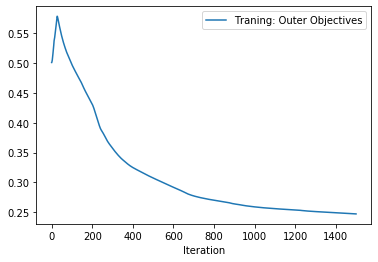

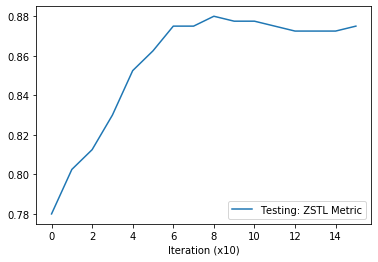

mean metric 0.875
rho for w_kb 1e-05; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 0.501081315757862; m train metric 0.8508333333333337; m test metric 0.78; align loss  0.01961294189095497
100/1500 o_loss 0.478363693652985; m train metric 0.8641666666666669; m test metric 0.8324999999999999; align loss  0.0074767558835446835
200/1500 o_loss 0.4110193850977036; m train metric 0.8770833333333338; m test metric 0.8325000000000001; align loss  0.007674127817153931
300/1500 o_loss 0.3543747437186539; m train metric 0.8900000000000006; m test metric 0.8549999999999999; align loss  0.008327887393534184
400/1500 o_loss 0.327038683645272; m train metric 0.8858333333333338; m test metric 0.8574999999999999; align loss  0.008946428075432777
500/1500 o_loss 0.3029065722793651; m train metric 0.8845833333333338; m test metric 0.8474999999999999; align loss  0.009520238265395164
600/1500 o_loss 0.28873244788264857; m train metric 0.8879166666666674; m

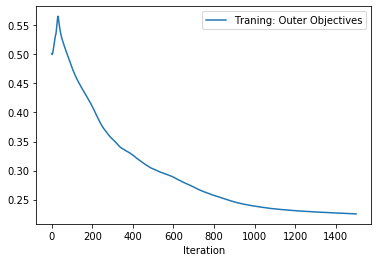

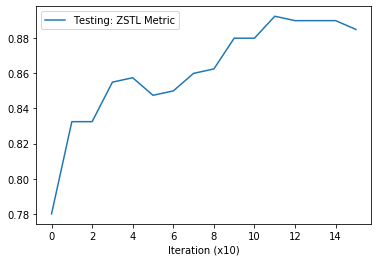

mean metric 0.8849999999999998
rho for w_kb 1e-05; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 0.501081315757862; m train metric 0.8508333333333336; m test metric 0.78; align loss  0.015233205631375313
100/1500 o_loss 0.49567122591348983; m train metric 0.863333333333334; m test metric 0.8474999999999998; align loss  0.0032043536193668842
200/1500 o_loss 0.39154743624385446; m train metric 0.8800000000000004; m test metric 0.8524999999999997; align loss  0.0032712812535464764
300/1500 o_loss 0.3591024950883972; m train metric 0.8812500000000006; m test metric 0.8599999999999998; align loss  0.0035452893935143948
400/1500 o_loss 0.3374999403138645; m train metric 0.8808333333333337; m test metric 0.8474999999999998; align loss  0.003945641219615936
500/1500 o_loss 0.29921000233540934; m train metric 0.8737500000000004; m test metric 0.8574999999999997; align loss  0.004238820169121027
600/1500 o_loss 0.26893498939073956; m train metric 0.8

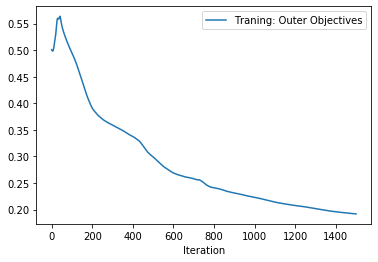

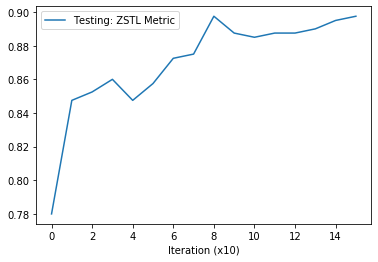

mean metric 0.8975
New best acc 0.8975
best_hp  {'mu': 1e-05, 'rho': 1e-05}


In [4]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)


indx = train_indx
val_indx = list(np.random.choice(indx, size=20, replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data = utils.Dataset([dataset[d] for d in val_indx])
train_splited_data = utils.Dataset([dataset[d] for d in train_indx_splited])
val_loader = DataLoader(val_data, batch_size=len(val_indx), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=len(train_indx_splited), shuffle=True)

best_hp = utils.hp_select_binClass(train_splited_loader, val_loader, support_loader, d, dm, net, shape_record)
print('best_hp ', best_hp)

5
{'rho': 1e-05, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
init mean test metric 0.8470000000000002; align loss 0.015483100898563862
1/1800 o_loss 0.5320221240515821; m train metric 0.8407142857142861; m test metric 0.8470000000000002; align loss  0.015256963670253754
100/1800 o_loss 0.5121106581679279; m train metric 0.8625000000000004; m test metric 0.8550000000000003; align loss  0.0030557133723050356
200/1800 o_loss 0.40919935237782606; m train metric 0.8771428571428576; m test metric 0.8570000000000002; align loss  0.0031174637842923403
300/1800 o_loss 0.3614301939694477; m train metric 0.8721428571428578; m test metric 0.861; align loss  0.0033656919840723276
400/1800 o_loss 0.3026916481903754; m train metric 0.8785714285714293; m test metric 0.873; align loss  0.0034305916633456945
500/1800 o_loss 0.2862717462720216; m train metric 0.8828571428571431; m test metric 0

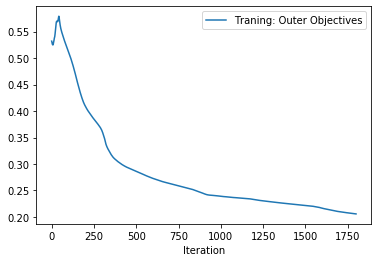

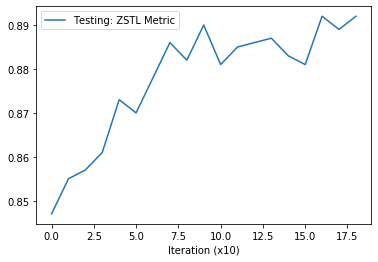

0

In [6]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)

param_dict = {}
param_dict['rho'] = best_hp['rho']
param_dict['mu'] = best_hp['mu']
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)


ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)
ZSTL_model.train(train_loader, test_loader, max_iter=1800)


In [9]:
def genSplits(dataset, train_size, test_size, support_size, T, train_batch_size=140):
    indx = [ x for x in range(len(dataset))]
    support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
    print(len(support_indx))
    temp = [x for x in indx if x not in support_indx]
    train_indx = list(np.random.choice(temp, size=train_size, replace=False))
    temp = [x for x in temp if x not in train_indx]
    print(len(train_indx))
    test_indx = temp
    print(len(test_indx))


    support_data = utils.Dataset([dataset[d] for d in support_indx])
    train_data = utils.Dataset([dataset[d] for d in train_indx])
    test_data = utils.Dataset([dataset[d] for d in test_indx])

    support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)

    return support_loader, train_loader, test_loader

train_size1 = 140
test_size1 = 50
support_size1 = 10
support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)

10
140
50


{'rho': 1e-05, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
10
140
50
init mean test metric 0.8630000000000001; align loss 0.011802337132394314
1/1800 o_loss 0.504765630456885; m train metric 0.8275000000000007; m test metric 0.8630000000000001; align loss  0.012674335390329361
100/1800 o_loss 0.5250939684337936; m train metric 0.8042857142857147; m test metric 0.8209999999999998; align loss  0.003884503385052085
200/1800 o_loss 0.42936097722766653; m train metric 0.8275000000000001; m test metric 0.857; align loss  0.003755581798031926
300/1800 o_loss 0.3922662755474448; m train metric 0.8335714285714289; m test metric 0.8669999999999998; align loss  0.00368019612506032
400/1800 o_loss 0.36527526518662595; m train metric 0.845357142857143; m test metric 0.875; align loss  0.003687833435833454
500/1800 o_loss 0.34373287530948543; m train metric 0.8521428571428571; m test metri

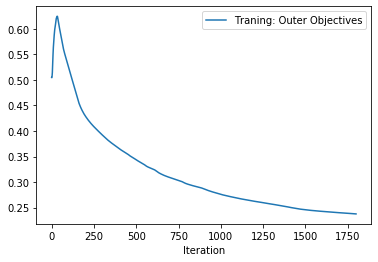

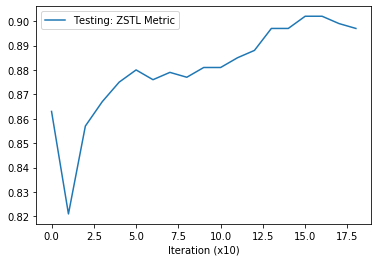

mean acc  tensor(0.8970, dtype=torch.float64)
10
140
50
init mean test metric 0.8219999999999998; align loss 0.04863705858588219
1/1800 o_loss 0.6312095760899995; m train metric 0.8142857142857145; m test metric 0.824; align loss  0.04515872523188591
100/1800 o_loss 0.5649036143839892; m train metric 0.8292857142857141; m test metric 0.8240000000000002; align loss  0.005952843464910984
200/1800 o_loss 0.4341949828700828; m train metric 0.8460714285714287; m test metric 0.8340000000000003; align loss  0.005771948024630547
300/1800 o_loss 0.38085268003799555; m train metric 0.8532142857142855; m test metric 0.8390000000000001; align loss  0.005719609558582306
400/1800 o_loss 0.3507461314588519; m train metric 0.8649999999999999; m test metric 0.8540000000000002; align loss  0.005648092366755009
500/1800 o_loss 0.3327671971837325; m train metric 0.8685714285714289; m test metric 0.8510000000000002; align loss  0.005653972737491131
600/1800 o_loss 0.32019812010029064; m train metric 0.8692

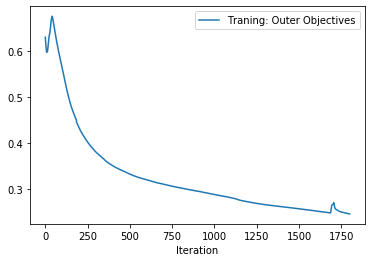

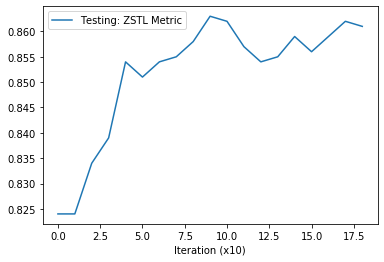

mean acc  tensor(0.8610, dtype=torch.float64)
10
140
50
init mean test metric 0.8209999999999998; align loss 0.03816579654812813
1/1800 o_loss 0.8860038541357166; m train metric 0.810714285714286; m test metric 0.8209999999999998; align loss  0.037344321608543396
100/1800 o_loss 0.8497114073069367; m train metric 0.8285714285714286; m test metric 0.8349999999999995; align loss  0.0072039393708109856
200/1800 o_loss 0.6594527423132344; m train metric 0.8314285714285715; m test metric 0.8439999999999998; align loss  0.006748010404407978
300/1800 o_loss 0.5104918192523266; m train metric 0.8446428571428578; m test metric 0.8489999999999998; align loss  0.006441289093345404
400/1800 o_loss 0.3642089482862502; m train metric 0.8500000000000005; m test metric 0.856; align loss  0.006300834007561207
500/1800 o_loss 0.32551748723822777; m train metric 0.8571428571428572; m test metric 0.865; align loss  0.006357262842357159
600/1800 o_loss 0.30589127296947743; m train metric 0.8639285714285716

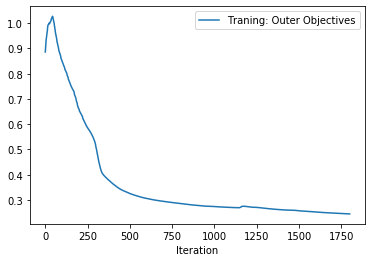

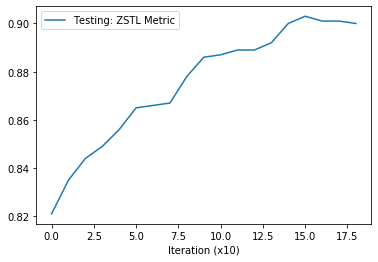

mean acc  tensor(0.9000, dtype=torch.float64)
10
140
50
init mean test metric 0.8580000000000002; align loss 0.00874273106455803
1/1800 o_loss 0.418293505825568; m train metric 0.8546428571428573; m test metric 0.8570000000000002; align loss  0.00866595096886158
100/1800 o_loss 0.36343632252121877; m train metric 0.8692857142857147; m test metric 0.8580000000000002; align loss  0.0027677619364112616
200/1800 o_loss 0.32856397213514094; m train metric 0.876428571428572; m test metric 0.8670000000000002; align loss  0.002678206190466881
300/1800 o_loss 0.3096903944803801; m train metric 0.8782142857142862; m test metric 0.8689999999999999; align loss  0.002675647847354412
400/1800 o_loss 0.2945564661457736; m train metric 0.882142857142857; m test metric 0.8719999999999999; align loss  0.0027223534416407347
500/1800 o_loss 0.282811976004658; m train metric 0.881071428571429; m test metric 0.871; align loss  0.0028452537953853607
600/1800 o_loss 0.2763926190357389; m train metric 0.879642

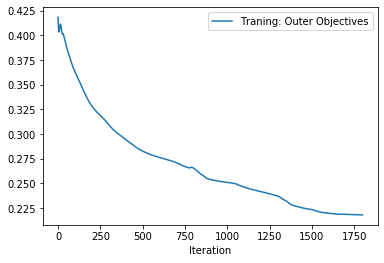

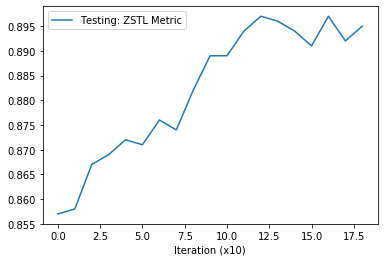

mean acc  tensor(0.8950, dtype=torch.float64)
10
140
50
init mean test metric 0.8359999999999999; align loss 0.03766448050737381
1/1800 o_loss 0.6439285059858646; m train metric 0.8321428571428575; m test metric 0.8349999999999999; align loss  0.03729966655373573
100/1800 o_loss 0.5683696724940092; m train metric 0.8328571428571431; m test metric 0.815; align loss  0.006475229747593403
200/1800 o_loss 0.4605409282692043; m train metric 0.8592857142857144; m test metric 0.841; align loss  0.006158131640404463
300/1800 o_loss 0.4109275770872565; m train metric 0.8642857142857144; m test metric 0.8570000000000002; align loss  0.005952873732894659
400/1800 o_loss 0.3793972086593775; m train metric 0.8703571428571429; m test metric 0.8590000000000003; align loss  0.005823352374136448
500/1800 o_loss 0.34561400800012054; m train metric 0.8710714285714288; m test metric 0.8620000000000003; align loss  0.005908227525651455
600/1800 o_loss 0.31115179702506535; m train metric 0.8821428571428578;

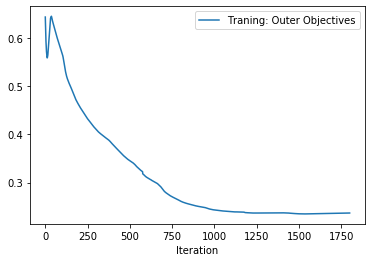

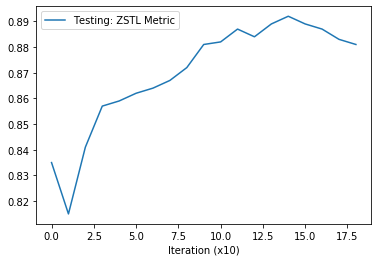

mean acc  tensor(0.8810, dtype=torch.float64)
10
140
50
init mean test metric 0.8439999999999999; align loss 0.02187095582485199
1/1800 o_loss 0.4372182300148; m train metric 0.8571428571428579; m test metric 0.8440000000000001; align loss  0.022507835179567337
100/1800 o_loss 0.41219548184391375; m train metric 0.8678571428571431; m test metric 0.8540000000000002; align loss  0.007112317718565464
200/1800 o_loss 0.3660914299726885; m train metric 0.8728571428571434; m test metric 0.8510000000000001; align loss  0.007049466948956251
300/1800 o_loss 0.33491632449108044; m train metric 0.877857142857143; m test metric 0.8630000000000002; align loss  0.007144076284021139
400/1800 o_loss 0.3109321880503558; m train metric 0.8803571428571432; m test metric 0.8600000000000001; align loss  0.007200891617685556
500/1800 o_loss 0.2922316683572717; m train metric 0.8871428571428576; m test metric 0.8630000000000002; align loss  0.007527847774326801
600/1800 o_loss 0.2648617652644004; m train met

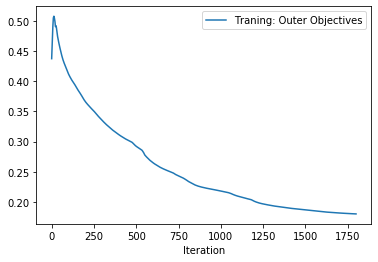

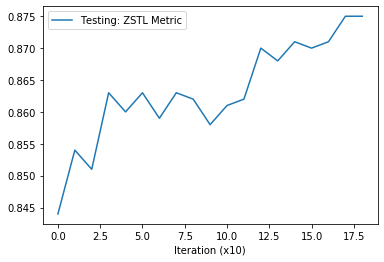

mean acc  tensor(0.8750, dtype=torch.float64)
10
140
50
init mean test metric 0.8440000000000001; align loss 0.01782955788075924
1/1800 o_loss 0.4008017661548885; m train metric 0.8464285714285715; m test metric 0.8440000000000001; align loss  0.020901460200548172
100/1800 o_loss 0.40331370909365694; m train metric 0.8550000000000003; m test metric 0.8490000000000001; align loss  0.009608400985598564
200/1800 o_loss 0.3575416585713226; m train metric 0.8635714285714282; m test metric 0.862; align loss  0.009644966572523117
300/1800 o_loss 0.32429757562432704; m train metric 0.8785714285714293; m test metric 0.8699999999999999; align loss  0.009618081152439117
400/1800 o_loss 0.29565659726670546; m train metric 0.8896428571428577; m test metric 0.8769999999999999; align loss  0.009080620482563972
500/1800 o_loss 0.2596090631925368; m train metric 0.9000000000000011; m test metric 0.8959999999999999; align loss  0.008636166341602802
600/1800 o_loss 0.2490720137271897; m train metric 0.90

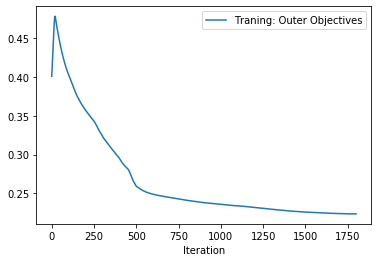

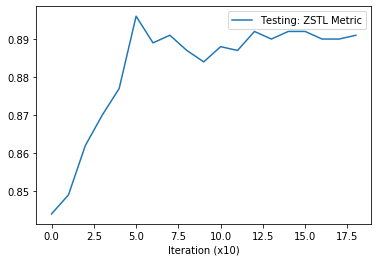

mean acc  tensor(0.8910, dtype=torch.float64)
10
140
50
init mean test metric 0.825; align loss 0.012680582702159882
1/1800 o_loss 0.5442860331253282; m train metric 0.8232142857142856; m test metric 0.826; align loss  0.01499613095074892
100/1800 o_loss 0.45473391272659813; m train metric 0.837142857142857; m test metric 0.838; align loss  0.002754323650151491
200/1800 o_loss 0.3855785200671692; m train metric 0.8514285714285718; m test metric 0.853; align loss  0.0026754667051136494
300/1800 o_loss 0.33303300396406227; m train metric 0.8692857142857148; m test metric 0.8649999999999998; align loss  0.0027093091048300266
400/1800 o_loss 0.3060556759093223; m train metric 0.8778571428571437; m test metric 0.873; align loss  0.002809967380017042
500/1800 o_loss 0.2840617549589037; m train metric 0.8867857142857151; m test metric 0.8780000000000002; align loss  0.0029928251169621944
600/1800 o_loss 0.2725391119286152; m train metric 0.8917857142857151; m test metric 0.878; align loss  0.

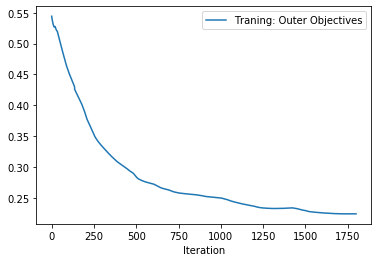

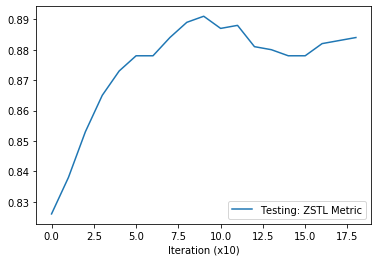

mean acc  tensor(0.8840, dtype=torch.float64)
10
140
50
init mean test metric 0.8050000000000002; align loss 0.02928508259356022
1/1800 o_loss 0.5807171454969128; m train metric 0.8139285714285716; m test metric 0.7970000000000002; align loss  0.030185282230377197
100/1800 o_loss 0.5621167285401109; m train metric 0.8300000000000003; m test metric 0.7759999999999999; align loss  0.01198204793035984
200/1800 o_loss 0.5089931551749552; m train metric 0.8350000000000001; m test metric 0.7889999999999998; align loss  0.011435655876994133
300/1800 o_loss 0.48190813946171795; m train metric 0.8392857142857144; m test metric 0.7930000000000001; align loss  0.011101233772933483
400/1800 o_loss 0.44655773083380024; m train metric 0.8417857142857141; m test metric 0.7979999999999998; align loss  0.010848922654986382
500/1800 o_loss 0.38346882117579556; m train metric 0.8457142857142856; m test metric 0.821; align loss  0.010223330929875374
600/1800 o_loss 0.3486087224313191; m train metric 0.855

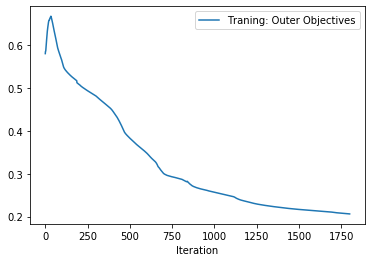

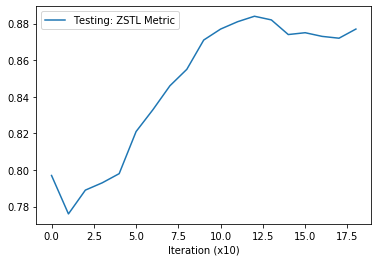

mean acc  tensor(0.8770, dtype=torch.float64)
10
140
50
init mean test metric 0.8180000000000001; align loss 0.012728764675557613
1/1800 o_loss 0.6997781800122799; m train metric 0.8239285714285716; m test metric 0.8190000000000001; align loss  0.012562408111989498
100/1800 o_loss 0.6249543666074585; m train metric 0.8375000000000004; m test metric 0.828; align loss  0.008074497804045677
200/1800 o_loss 0.5315439844603783; m train metric 0.8575000000000004; m test metric 0.8430000000000001; align loss  0.0070045096799731255
300/1800 o_loss 0.43956415974535046; m train metric 0.8646428571428578; m test metric 0.8560000000000001; align loss  0.006617903709411621
400/1800 o_loss 0.38974142853736077; m train metric 0.8682142857142863; m test metric 0.851; align loss  0.006365268025547266
500/1800 o_loss 0.3351730360799203; m train metric 0.8700000000000007; m test metric 0.857; align loss  0.006207107566297054
600/1800 o_loss 0.3090566123004204; m train metric 0.8685714285714292; m test me

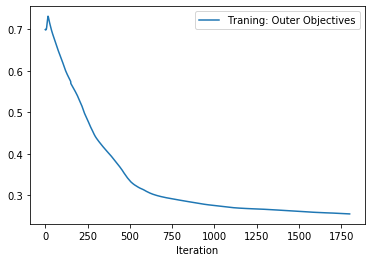

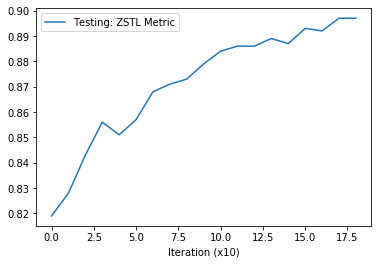

mean acc  tensor(0.8970, dtype=torch.float64)
[array(0.897), array(0.861), array(0.9), array(0.895), array(0.881), array(0.875), array(0.891), array(0.884), array(0.877), array(0.897)]
0.8857999999999999
(0.8768792065010977, 0.8947207934989021)
[-0.00892079  0.00892079]


In [17]:
exp_results = []
Run = 10
print(param_dict)
for r in range(Run):
    support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)
    ZSTL_model.train(train_loader, test_loader, max_iter=1800)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    exp_results.append(utils.toNumpy(mean_acc))

import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

In [18]:
import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

[array(0.897), array(0.861), array(0.9), array(0.895), array(0.881), array(0.875), array(0.891), array(0.884), array(0.877), array(0.897)]
0.8857999999999999
(0.8768792065010977, 0.8947207934989021)
[-0.00892079  0.00892079]
